In [132]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import cv2
from matplotlib.backends.backend_agg import FigureCanvas
import os
from scipy.ndimage import convolve1d

from utils.parse_config import *
from utils.collection import *
from utils.visualizer import *
sys.path.insert(0, '..')

In [141]:
num_rx = 4
num_tx = 4
start_freq = 77 # GHz
idle_time = 10 # usec
adc_start_time = 6 # usec
ramp_end_time = 120 # usec, ramp_end_time = adc_start_time + adc_sample_time(per chirp) + extral_time
chirp_slope =  29.982 # MHz/usec
num_adc_samples = 1024
adc_sample_rate = 10 # Msps
num_frames = 256
num_chirps = 255
adc_sample_time = num_adc_samples/adc_sample_rate # usec

frame_duration = (ramp_end_time+idle_time)*num_chirps*1e-6 # sec
frame_act_ratio = adc_sample_time/(ramp_end_time+idle_time)
frame_start_timestamps = [i*frame_duration+adc_start_time*1e-6 for i in range(num_frames)] # usec
frame_sample_time = [[i*frame_duration, i*frame_duration+adc_sample_time] for i in range(num_frames)] # [frame_start, frame_end] usec

print(f"Number of Rx Antennas: {num_rx}")
print(f"Number of Tx Antennas: {num_tx}")
print(f"Start Frequency: {start_freq} GHz")
print(f"Idle Time: {idle_time} usec")
print(f"ADC Start Time Time: {adc_start_time} usec")
print(f'ADC sample time: {adc_sample_time} usec')
print(f"Ramp End Time: {ramp_end_time} usec") # this should really be called ramp to end? or maybe just chirptime?
print(f"Chirp Slope: {chirp_slope} MHz/usec")
print(f"Number of ADC Samples: {num_adc_samples}")
print(f"ADC sample rate: {adc_sample_rate} Msps")
print(f'Frame Duration:{frame_duration:.4f} sec')
print(f'FPS:{int(1/(frame_duration))}')
print(f'Frame Active Ratio:{frame_act_ratio:.4f}')

num_chirps = num_chirps*num_tx

Number of Rx Antennas: 4
Number of Tx Antennas: 4
Start Frequency: 77 GHz
Idle Time: 10 usec
ADC Start Time Time: 6 usec
ADC sample time: 102.4 usec
Ramp End Time: 120 usec
Chirp Slope: 29.982 MHz/usec
Number of ADC Samples: 1024
ADC sample rate: 10 Msps
Frame Duration:0.0331 sec
FPS:30
Frame Active Ratio:0.7877


adc_raw shape:(1069490176,)
255 received
tx0:(255, 255, 4, 1024)
tx1:(255, 255, 4, 1024)
tx2:(255, 255, 4, 1024)
tx3:(255, 255, 4, 1024)
virtual:(255, 255, 16, 1024)
adc_data shape:(255, 16, 1024)


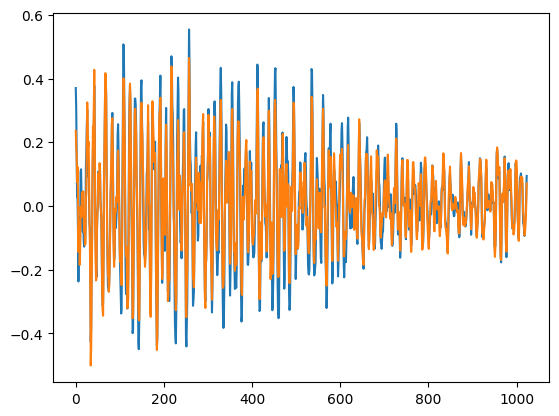

In [142]:
cap = 7
paths = [f'../rawData/cap{cap}/data_Raw_{i}.bin' for i in range(2)]
# path1 = f'D:/rawData/cap7/data_Raw_1.bin'

rad_range = np.arange(start=0, stop=np.pi, step=np.pi/(num_adc_samples))
rad_doppler = np.arange(start=-np.pi/2, stop=np.pi/2, step=np.pi/(num_chirps//num_tx))

adc_raw = []
for path in paths:
    adc_raw.append(np.fromfile(path, dtype=np.int16))
adc_raw = np.concatenate(adc_raw, axis=0)
print(f'adc_raw shape:{adc_raw.shape}')

nframes = adc_raw.shape[0] // (num_adc_samples*num_chirps*num_rx)
assert adc_raw.shape[0] == num_adc_samples*num_chirps*num_rx*num_frames or 0 < nframes <num_frames
print(f'{nframes} received')
adc_raw = adc_raw[ :num_adc_samples*num_chirps*num_rx*nframes]

adc_frames = adc_raw.reshape(nframes, num_chirps, num_rx, num_adc_samples)
adc_tx = []
for i in range(num_tx):
    adc_tx.append(adc_frames[:, i::num_tx, :, :])
    print(f'tx{i}:{adc_tx[-1].shape}')
adc_frames = np.concatenate(adc_tx, axis=-2)
print(f'virtual:{adc_frames.shape}')

adc_frames = adc_frames/np.max(adc_frames)
adc_data = adc_frames[22]
print(f'adc_data shape:{adc_data.shape}')

plt.plot(adc_frames[19, 50, 1])
plt.plot(adc_frames[19, 100, 1])

In [143]:
LIGHT_SPEED = 299792458 # m/s
# range_resolution, bandwidth = compute_range_resolution(adc_sample_rate, num_adc_samples, chirp_slope)
bandwidth = chirp_slope*ramp_end_time*1e6
range_resolution = LIGHT_SPEED/(2*bandwidth)
max_range = range_resolution * num_adc_samples
print(f'range_resolution: {range_resolution}, max_range: {max_range}')

num_chirps = adc_data.shape[0]
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec

doppler_resolution = compute_doppler_resolution(num_chirps, bandwidth, chirp_interval, num_tx)
max_doppler = doppler_resolution * num_chirps / 2

print(f'doppler_resolution: {doppler_resolution}, doppler_resolution: {max_doppler}')

ranges = np.arange(0, max_range + range_resolution, range_resolution)
range_ticks = np.arange(0, len(ranges)/4, len(ranges)//40)
range_tick_labels = ranges[::len(ranges)//10].round(2)
print(ranges.shape, range_ticks.shape, range_tick_labels.shape)

range_resolution: 0.04166283909234429, max_range: 42.662747230560555
doppler_resolution: 6.28371883182693e-07, doppler_resolution: 8.011741510579336e-05
(1025,) (11,) (11,)


In [146]:
adc_data.min(), adc_data.max()

(-0.7528187337380746, 0.7831743278404163)

steering_vector shape: (181, 16)
range_azimuth mean:  23.893658
Threshold scale factor: 25.9473


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


nbins in total:46336, ndetected: 2113.0
range_dect:3821, angle_dect: 6728


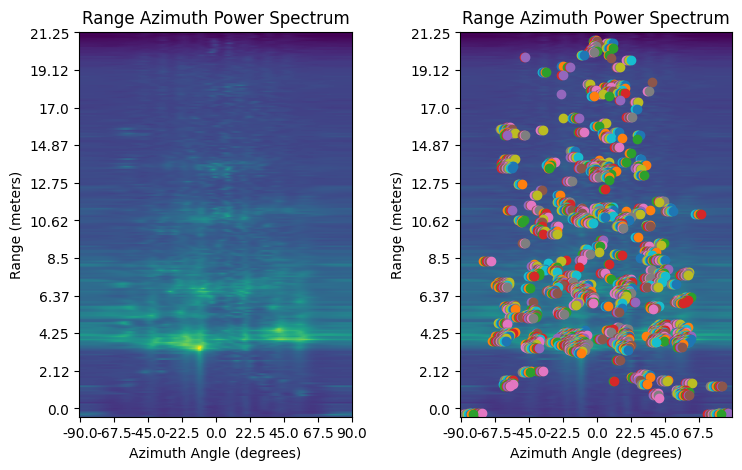

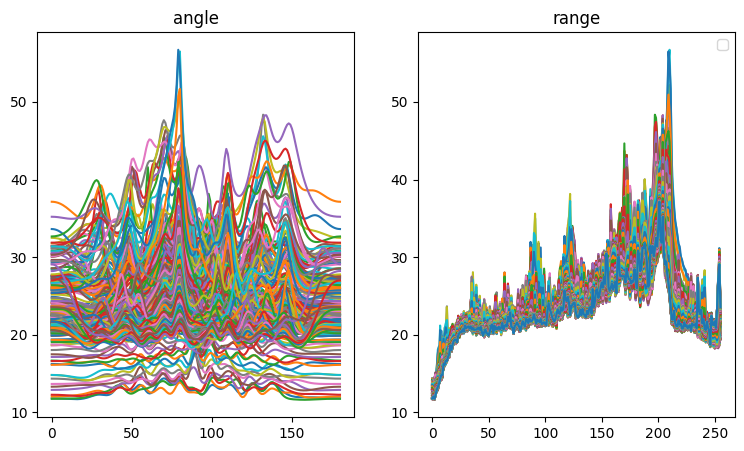

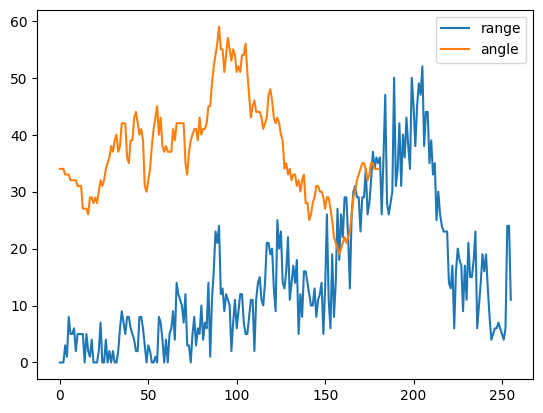

In [147]:
ranges_real = np.arange(0, max_range/2 + range_resolution, range_resolution)
range_ticks_real = np.arange(0, len(ranges_real)/2, len(ranges_real)//20)
range_tick_labels_real = ranges_real[::len(ranges_real)//10].round(2)[::-1]

range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0) #[range, channel, doppler]
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2) #[range, channel, doppler]

## Beamformer
steering_vector = compute_steering_vector(num_ant=num_tx*num_rx, angle_res=1.0, angle_rng=90)
print('steering_vector shape:', steering_vector.shape)

n_range_bins = range_doppler.shape[0]
n_angles = steering_vector.shape[0]
range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)
for i in range(range_doppler.shape[0]):
    range_azimuth[i,:] = aoa_capon(range_doppler[i, ...], steering_vector)
range_azimuth = np.flipud(range_azimuth)[range_azimuth.shape[0]//2:, :][::2]
range_azimuth = 10*np.log10(np.abs(range_azimuth))
print('range_azimuth mean: ', np.mean(range_azimuth))

fig, ax = plt.subplots(1, 2, figsize=(9, 5))
for i in range(2):
    ax[i].imshow(range_azimuth)
    ax[i].set_title("Range Azimuth Power Spectrum")
    ax[i].set_xlabel("Azimuth Angle (degrees)")
    ax[i].set_ylabel("Range (meters)")
    ax[i].set_yticks(range_ticks_real, range_tick_labels_real)
    ax[i].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1))

# CFAR Cell sizes
gaurd_len = 3
train_len = 12

# compute threshold scale factor
p_fa = 0.000001 # Probability of False Alarm
a = train_len*(p_fa**(-1/train_len) - 1)
print(f"Threshold scale factor: {a:.4f}")
# Threshold scale factor: 3.4028

cfar_kernel = np.ones((1 + 2*gaurd_len + 2*train_len), dtype=float) / (2*train_len)
cfar_kernel[train_len: train_len + (2*gaurd_len) + 1] = 0.

xall = range_azimuth
detected = np.ones_like(xall)

fig1, ax1 = plt.subplots(1, 2, figsize=(9, 5))
for i in range(xall.shape[0]):
    ax1[0].plot(xall[i, :])

for i in range(xall.shape[1]):
    ax1[1].plot(xall[:, i])

ax1[0].set_title('angle')
ax1[1].set_title('range')
plt.legend()

range_bins, angle_bins = xall.shape
range_dect, angle_dect = [], []
for bi in range(0, range_bins):
    x = xall[bi]
    noise_level = convolve1d(x, cfar_kernel, mode='nearest')
    threshold = noise_level + np.log10(a)
    d = xall[bi, :] > threshold
    detected[bi] *= d
    range_dect.append(sum(d))
    # print(f'range bin: {bi}, ndetected: {np.sum(d)}')

for bi in range(0, angle_bins):
    x = xall[:, bi]
    noise_level = convolve1d(x, cfar_kernel, mode='nearest')
    threshold = noise_level + np.log10(a)
    d = xall[:, bi] > threshold
    detected[:, bi] *= d
    angle_dect.append(sum(d))
    # print(f'angle bin: {bi}, ndetected: {np.sum(d)}')

print(f'nbins in total:{range_bins*angle_bins}, ndetected: {np.sum(detected)}')
print(f'range_dect:{sum(range_dect)}, angle_dect: {sum(angle_dect)}')

for i in range(detected.shape[0]):
    for j in range(detected.shape[1]):
        if detected[i][j] == 1:
            ax[1].scatter(j, i)

fig2, ax2 = plt.subplots(1,1)
ax2.plot(range_dect, label='range')
ax2.plot(angle_dect, label='angle')
plt.legend()

ranges_real (513,)
range_ticks_real (11,)
range_tick_labels_real (11,)
(1024, 4, 255)
steering_vector shape: (181, 4)
(512, 181)
steering_vector shape: (181, 16)
(512, 181)


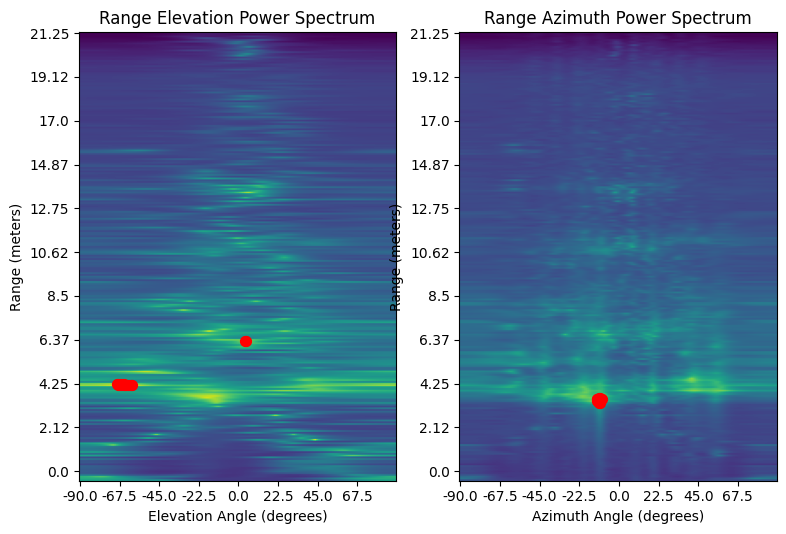

In [86]:
## Perform 2d FFT for azimuth-elevation estimation
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0) #[range, channel, doppler]
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2) #[range, channel, doppler]

angles = ['Elevation', 'Azimuth']
num_ant = [num_tx, num_rx*num_tx]

ranges_real = np.arange(0, max_range/2 + range_resolution, range_resolution)
range_ticks_real = np.arange(0, len(ranges_real)/2, len(ranges_real)//20)

range_tick_labels_real = ranges_real[::len(ranges_real)//10].round(2)[::-1]
print('ranges_real', ranges_real.shape)

# range_ticks_real = range_ticks[range_ticks.shape[0]//2: ]
# range_tick_labels_real = range_tick_labels[::-1][range_tick_labels.shape[0]//2: ]
print('range_ticks_real', range_ticks_real.shape)
print('range_tick_labels_real', range_tick_labels_real.shape)

angle_peaks = {'Elevation':[], 'Azimuth':[]}
range_peaks = {'Elevation':[], 'Azimuth':[]}

fig, ax = plt.subplots(1, len(num_ant), figsize=(9, 10))
for i, (n, angle) in enumerate(zip(num_ant, angles)):
    if angle == 'Elevation':
        range_doppler_mean = range_doppler.reshape(range_doppler.shape[0], num_rx, num_tx, range_doppler.shape[-1])
        range_doppler_mean = np.mean(range_doppler_mean, axis=1)
        print(range_doppler_mean.shape)
    else:
        range_doppler_mean = range_doppler

    ## Beamformer
    steering_vector = compute_steering_vector(num_ant=n, angle_res=1.0, angle_rng=90)
    print('steering_vector shape:', steering_vector.shape)

    n_range_bins = range_doppler_mean.shape[0]
    n_angles = steering_vector.shape[0]
    range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)
    for range_i in range(range_doppler_mean.shape[0]):
        range_azimuth[range_i,:] = aoa_capon(range_doppler_mean[range_i, ...], steering_vector)
    range_azimuth = np.flipud(range_azimuth)
    range_azimuth = 10*np.log10(np.abs(range_azimuth))
    range_azimuth = range_azimuth[range_azimuth.shape[0]//2:, :]

    npoints = 16
    indices = np.argpartition(range_azimuth[:].flatten(), -npoints)[-npoints: ]
    peak_idx = np.unravel_index(indices, range_azimuth.shape)
    range_bins, doppler_bins = peak_idx

    print(range_azimuth.shape)
    ax[i].imshow(range_azimuth[::2, :])
    ax[i].set_title(f"Range {angle} Power Spectrum")
    ax[i].set_xlabel(f"{angle} Angle (degrees)")
    ax[i].set_ylabel("Range (meters)")
    ax[i].set_yticks(range_ticks_real, range_tick_labels_real)
    ax[i].set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1))

    for r, d in zip(range_bins, doppler_bins):
        # print(r//4, d, x, y)
        x, y = np.linspace(-90, 90, 181).round(1)[d], np.arange(start=0, stop=range_resolution*num_adc_samples//2, step=range_resolution)[::-1][r]
        ax[i].scatter(d, r//2, s=50, c='r')
        angle_peaks[angle].append(x)
        range_peaks[angle].append(y)

In [12]:
print(angle_peaks)
print(range_peaks)

{'Elevation': [-69.0, -67.0, -65.0, -68.0, 4.0, -60.0, -68.0, -66.0, -67.0, -66.0, 5.0, -64.0, -63.0, -62.0, -61.0, -65.0], 'Azimuth': [-11.0, -9.0, -12.0, -11.0, -11.0, -10.0, -12.0, -10.0, -12.0, -10.0, -10.0, -10.0, -10.0, -11.0, -11.0, -11.0]}
{'Elevation': [4.291272426511462, 4.291272426511462, 4.291272426511462, 4.291272426511462, 6.332751542036332, 4.249609587419118, 4.249609587419118, 4.291272426511462, 4.249609587419118, 4.249609587419118, 6.332751542036332, 4.249609587419118, 4.249609587419118, 4.249609587419118, 4.249609587419118, 4.249609587419118], 'Azimuth': [3.416352805572232, 3.5830041619416093, 3.5830041619416093, 3.5830041619416093, 3.4580156446645764, 3.5830041619416093, 3.4996784837569206, 3.416352805572232, 3.5413413228492647, 3.4996784837569206, 3.5413413228492647, 3.4580156446645764, 3.6246670010339535, 3.6246670010339535, 3.4996784837569206, 3.5413413228492647]}


In [13]:
NUM_RX=num_rx
NUM_SAMPLES=num_adc_samples
NUM_CHIRPS=num_chirps
NUM_FRAMES_=num_frames
RANGE_FFT_SIZE = NUM_SAMPLES
DOPPLER_FFT_SIZE = NUM_CHIRPS
ELEVATION_DIM=num_tx
AZIMUTH_DIM=num_rx
ELEVATION_FFT_SIZE=181
AZIMUTH_FFT_SIZE=181
azimuth_axis = (np.pi)*np.linspace(-AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE)/AZIMUTH_FFT_SIZE
elevation_axis = (np.pi)*np.linspace(-ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE)/ELEVATION_FFT_SIZE

z_range = range_tick_labels[: len(range_tick_labels)//2, None]*np.sin(elevation_axis)[..., None].transpose()
r_range = range_tick_labels[: len(range_tick_labels)//2, None]*np.cos(elevation_axis)[..., None].transpose()
x_range = np.zeros((r_range.shape[0], r_range.shape[1], azimuth_axis.shape[0]))
for i in range(x_range.shape[0]):
    for j in range(x_range.shape[1]):
        x_range[i, j, :] = r_range[i, j]*np.sin(azimuth_axis)

y_range = np.zeros((r_range.shape[0], r_range.shape[1], azimuth_axis.shape[0]))
for i in range(x_range.shape[0]):
    for j in range(x_range.shape[1]):
        y_range[i, j, :] = r_range[i, j]*np.cos(azimuth_axis)

print(z_range.shape)
print(z_range.min(), z_range.max())
print(r_range.shape)
print(r_range.min(), r_range.max())
print(x_range.shape)
print(x_range.min(), x_range.max())
print(y_range.shape)
print(y_range.min(), y_range.max())

(5, 181)
-17.0 17.0
(5, 181)
0.0 17.0
(5, 181, 181)
-17.0 17.0
(5, 181, 181)
0.0 17.0


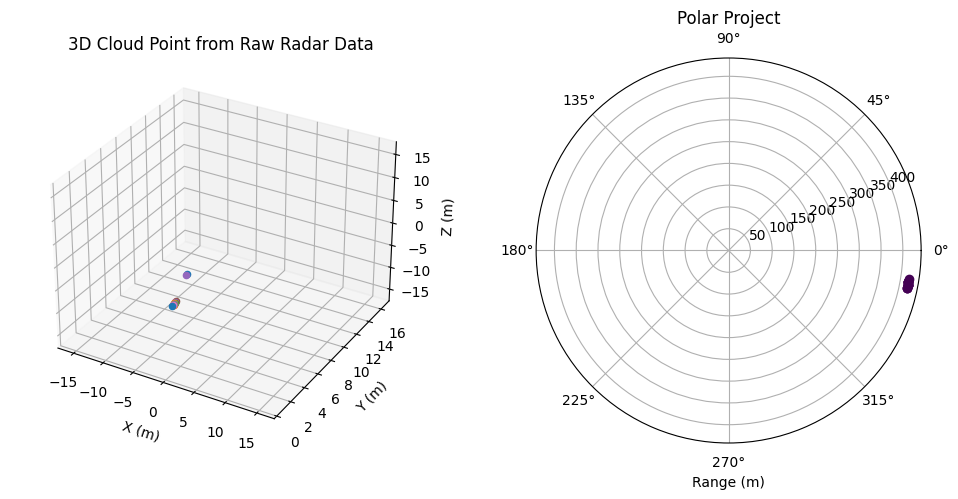

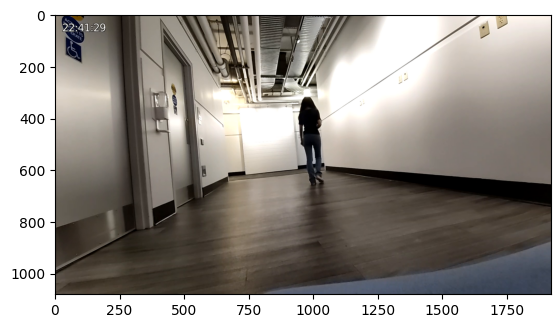

In [14]:

fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5), frameon=False)
canvas = FigureCanvas(fig3)
for spine in ax3[0].spines.values():
    spine.set_visible(False)
for spine in ax3[1].spines.values():
    spine.set_visible(False)
ax3[0].axis('off')
ax3[1].axis('off')
ax3[0] = fig3.add_subplot(1, 2, 1, projection='3d')
ax3[1] = fig3.add_subplot(1, 2, 2, projection='polar')

peak_azimuths = angle_peaks['Azimuth']
peak_elevations = angle_peaks['Elevation']
peak_ranges = range_peaks['Azimuth']

for azim, elev, rang in zip(peak_azimuths, peak_elevations, peak_ranges):
    azim = np.pi*azim/180
    elev = np.pi*elev/180
    # AoA estimation
    # Range to Cartesian conversion
    x = rang * np.cos(elev) * np.sin(azim)
    y = rang * np.cos(elev) * np.cos(azim)
    z = rang * np.sin(elev)
    # print(f'azim_bin:{azim_bin}, elev_bin:{elev_bin}, theta:{(180/np.pi)*theta:.2f}, phi:{(180/np.pi)*phi:.2f}, r:{r:.2f}, range_bin:{range_bin}, x: {x}, y: {y}, z: {z}')
    ax3[0].scatter(x, y, z)
    ax3[1].scatter(azim, r, c=z, cmap='viridis')

ax3[0].set_xlabel('X (m)')
ax3[0].set_ylabel('Y (m)')
ax3[0].set_zlabel('Z (m)')
ax3[0].set_title('3D Cloud Point from Raw Radar Data')
ax3[0].set_xlim3d([x_range.min(), x_range.max()])
ax3[0].set_ylim3d([y_range.min(), y_range.max()])
ax3[0].set_zlim3d([z_range.min(), z_range.max()])

ax3[1].set_xlabel('Range (m)')
ax3[1].set_title('Polar Project')
canvas.draw()
point3d = np.array(canvas.renderer.buffer_rgba())

img = Image.open(f'../rawData/cap{cap}/frames/frame_570.png')
fig = plt.figure()
plt.imshow(np.array(img))


In [ ]:
frames_stack = []
data_dict = {}

read_frames = True # Read RGB frames from local if already save
if read_frames:
    frames = []
    broken_file = []
    files = os.listdir(f'../rawData/cap{cap}/frames/')
    for fi, f in enumerate(files):
        if fi%100 == 0: print(f'{fi} imgs loaded.')
        try:
            img = Image.open(f'../rawData/cap{cap}/frames/{f}')
            frames.append(np.array(img))
        except OSError:
            broken_file.append(fi)
            continue
        # if fi>20: break
    frames = np.array(frames)

data_dict['radar'] = adc_frames # [frames, chirps, channels, samples]
data_dict['rgb'] = frames if read_frames else np.array([frames[frame_i] for frame_i in frame_nums]) 
print('radar shape: ', data_dict['radar'].shape)
print('rgb shape: ', data_dict['rgb'].shape)

NUM_RX=num_rx
NUM_SAMPLES=num_adc_samples
NUM_CHIRPS=num_chirps
NUM_FRAMES_=num_frames
RANGE_FFT_SIZE = NUM_SAMPLES
DOPPLER_FFT_SIZE = NUM_CHIRPS
ELEVATION_DIM=num_tx
AZIMUTH_DIM=num_rx
ELEVATION_FFT_SIZE=181
AZIMUTH_FFT_SIZE=181

for i in range(min(len(data_dict['radar']), len(data_dict['rgb']))):

    adc_data = data_dict['radar'][i, ...]
    ## Perform 2d FFT for azimuth-elevation estimation
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0) #[range, channel, doppler]
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2) #[range, channel, doppler]

    angles = ['Elevation', 'Azimuth']
    num_ant = [num_tx, num_rx*num_tx]

    ranges_real = np.arange(0, max_range/2 + range_resolution, range_resolution)
    range_ticks_real = np.arange(0, len(ranges_real)/2, len(ranges_real)//20)

    range_tick_labels_real = ranges_real[::len(ranges_real)//10].round(2)[::-1]
    # print('ranges_real', ranges_real.shape)
    # print('range_ticks_real', range_ticks_real.shape)
    # print('range_tick_labels_real', range_tick_labels_real.shape)

    angle_peaks = {'Elevation':[], 'Azimuth':[]}
    range_peaks = {'Elevation':[], 'Azimuth':[]}

    for pi, (n, angle) in enumerate(zip(num_ant, angles)):
        if angle == 'Elevation':
            range_doppler_mean = range_doppler.reshape(range_doppler.shape[0], num_rx, num_tx, range_doppler.shape[-1])
            range_doppler_mean = np.mean(range_doppler_mean, axis=1)
            # print(range_doppler_mean.shape)
        else:
            range_doppler_mean = range_doppler

        ## Beamformer
        steering_vector = compute_steering_vector(num_ant=n, angle_res=1.0, angle_rng=90)
        # print('steering_vector shape:', steering_vector.shape)

        n_range_bins = range_doppler_mean.shape[0]
        n_angles = steering_vector.shape[0]
        range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)
        for range_i in range(range_doppler_mean.shape[0]):
            range_azimuth[range_i,:] = aoa_capon(range_doppler_mean[range_i, ...], steering_vector)
        range_azimuth = np.flipud(range_azimuth)
        range_azimuth = 10*np.log10(np.abs(range_azimuth))
        range_azimuth = range_azimuth[range_azimuth.shape[0]//2:, :]

        npoints = 16
        indices = np.argpartition(range_azimuth[:].flatten(), -npoints)[-npoints: ]
        peak_idx = np.unravel_index(indices, range_azimuth.shape)
        range_bins, doppler_bins = peak_idx

        for r, d in zip(range_bins, doppler_bins):
            x, y = np.linspace(-90, 90, 181).round(1)[d], range_resolution*np.arange(start=0, stop=num_adc_samples//2, step=1)[::-1][r]
            angle_peaks[angle].append(x)
            range_peaks[angle].append(y)

        range_azimuth = cv2.normalize(range_azimuth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        range_azimuth = range_azimuth[:, :, None].repeat(3, axis=2) # make 3 channel
        
    fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5), frameon=False)
    canvas = FigureCanvas(fig3)
    for spine in ax3[0].spines.values():
        spine.set_visible(False)
    for spine in ax3[1].spines.values():
        spine.set_visible(False)
    ax3[0].axis('off')
    ax3[1].axis('off')
    ax3[0] = fig3.add_subplot(1, 2, 1, projection='3d')
    ax3[1] = fig3.add_subplot(1, 2, 2, projection='polar')

    peak_azimuths = angle_peaks['Azimuth']
    peak_elevations = angle_peaks['Elevation']
    peak_ranges = range_peaks['Azimuth']

    for azim, elev, rang in zip(peak_azimuths, peak_elevations, peak_ranges):
        azim = np.pi*azim/180
        elev = np.pi*elev/180
        x = rang * np.cos(elev) * np.sin(azim)
        y = rang * np.cos(elev) * np.cos(azim)
        z = rang * np.sin(elev)
        ax3[0].scatter(x, y, z)
        ax3[1].scatter(azim, r, c=z, cmap='viridis')

    ax3[0].set_xlabel('X (m)')
    ax3[0].set_ylabel('Y (m)')
    ax3[0].set_zlabel('Z (m)')
    ax3[0].set_title('3D Cloud Point from Raw Radar Data')
    ax3[0].set_xlim3d([x_range.min(), x_range.max()])
    ax3[0].set_ylim3d([y_range.min(), y_range.max()])
    ax3[0].set_zlim3d([z_range.min(), z_range.max()])

    ax3[1].set_xlabel('Range (m)')
    ax3[1].set_title('Polar Project')
    canvas.draw()
    point3d = np.array(canvas.renderer.buffer_rgba())

        # obtain rgb image and resize
    rgb = data_dict['rgb'][i]
    ih, iw = rgb.shape[:2]
    ratio = ih / range_azimuth.shape[0]
    iw2, ih2 = int(iw/ratio), int(ih/ratio)
    rgb = cv2.resize(rgb, (iw2, ih2))

    ih, iw = point3d.shape[:2]
    ratio = ih / range_azimuth.shape[0]
    iw2, ih2 = int(iw/ratio), int(ih/ratio)
    point3d = cv2.resize(point3d, (iw2, ih2))

    range_azimuth = cv2.resize(range_azimuth, (2*range_azimuth.shape[1], range_azimuth.shape[0]))

    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    zero_pad = np.zeros((ih2, 4, 3), dtype=np.uint8)
    frame = np.hstack((rgb, zero_pad, range_azimuth, zero_pad, point3d[:, :, :3]))
    frames_stack.append(frame)

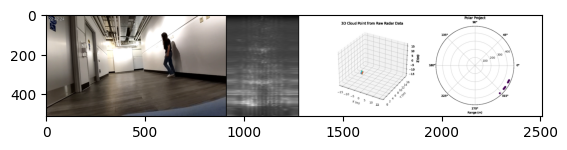

In [ ]:
plt.imshow(frames_stack[-1])

In [ ]:
fp_out = f"../rawData/cap{cap}/cap{cap}_azimuth_test.gif" # Path to output GIF file

img, *imgs = [Image.fromarray(frame) for frame in frames_stack]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)

In [ ]:
## Load video
reader = imageio.get_reader(f'../rawData/cap{cap}/socket_cap{cap}.mp4', 'ffmpeg')
fps = 30 # reader.get_meta_data()["fps"]
duration = 0.240*num_frames  #sec, radar duration #reader.get_meta_data()["duration"]
expected_frames = int(fps * duration)
discard_frames = fps*60 # radar takes about 1 min to start 
print(f'fps:{fps}, duration:{duration}, expected_frames:{expected_frames}')
frames = []
for i, frame in enumerate(reader):
    if i < discard_frames:
        del frame
    else:
        frames.append(frame)

fps:30, duration:61.44, expected_frames:1843


In [ ]:
# Find the start start frame aligning with radar start time, downsample and save frames
radar_duration = 5 # sec
fps = 30
start = 418
frame_act = int(30*1)


radar_frame_starttime = [i*round(0.24, 6) for i in range(num_frames)] # sec
radar_frame_endtime = [i*0.24+num_chirps*(idle_time+ramp_end_time)*1e-6 for i in range(num_frames)] # sec
radar_frame_starttime_to_rgb_nframe = [round(radar_frame_starttime[i]/(1/fps)) for i in range(num_frames)]
radar_frame_time_to_rgb_nframe = [round((radar_frame_endtime[i]-radar_frame_starttime[i])/(1/fps)) for i in range(num_frames)]
rgb_frame_save = [start + frame_strat + nframe for frame_strat, nframe in zip(radar_frame_starttime_to_rgb_nframe, radar_frame_time_to_rgb_nframe)]
print('radar_frame_starttime_to_rgb_nframe', radar_frame_starttime_to_rgb_nframe)
print('radar_frame_time_to_rgb_nframe', radar_frame_time_to_rgb_nframe)
print('rgb_frame_save', rgb_frame_save)

frame_nums = []
for frame_i in rgb_frame_save:
    im = Image.fromarray(frames[frame_i])
    im.save(f'../rawData/cap{cap}/frames/frame_{frame_i}.png')
    # im.show() # to find the start start frame aligning with radar start time,
    # frame_nums.append(i)
print(f'frame nums: len{frame_nums}')

radar_frame_starttime_to_rgb_nframe [0, 7, 14, 22, 29, 36, 43, 50, 58, 65, 72, 79, 86, 94, 101, 108, 115, 122, 130, 137, 144, 151, 158, 166, 173, 180, 187, 194, 202, 209, 216, 223, 230, 238, 245, 252, 259, 266, 274, 281, 288, 295, 302, 310, 317, 324, 331, 338, 346, 353, 360, 367, 374, 382, 389, 396, 403, 410, 418, 425, 432, 439, 446, 454, 461, 468, 475, 482, 490, 497, 504, 511, 518, 526, 533, 540, 547, 554, 562, 569, 576, 583, 590, 598, 605, 612, 619, 626, 634, 641, 648, 655, 662, 670, 677, 684, 691, 698, 706, 713, 720, 727, 734, 742, 749, 756, 763, 770, 778, 785, 792, 799, 806, 814, 821, 828, 835, 842, 850, 857, 864, 871, 878, 886, 893, 900, 907, 914, 922, 929, 936, 943, 950, 958, 965, 972, 979, 986, 994, 1001, 1008, 1015, 1022, 1030, 1037, 1044, 1051, 1058, 1066, 1073, 1080, 1087, 1094, 1102, 1109, 1116, 1123, 1130, 1138, 1145, 1152, 1159, 1166, 1174, 1181, 1188, 1195, 1202, 1210, 1217, 1224, 1231, 1238, 1246, 1253, 1260, 1267, 1274, 1282, 1289, 1296, 1303, 1310, 1318, 1325, 1332, 13

In [ ]:
frames_stack = []
data_dict = {}

read_frames = True # Read RGB frames from local if already save
if read_frames:
    frames = []
    broken_file = []
    files = os.listdir(f'../rawData/cap{cap}/frames/')
    for fi, f in enumerate(files):
        if fi%100 == 0: print(f'{fi} imgs loaded.')
        try:
            img = Image.open(f'../rawData/cap{cap}/frames/{f}')
            frames.append(np.array(img))
        except OSError:
            broken_file.append(fi)
            continue
    frames = np.array(frames)

data_dict['radar'] = adc_frames # [frames, chirps, channels, samples]
data_dict['rgb'] = frames if read_frames else np.array([frames[frame_i] for frame_i in frame_nums]) 
print('radar shape: ', data_dict['radar'].shape)
print('rgb shape: ', data_dict['rgb'].shape)

NUM_RX=num_rx
NUM_SAMPLES=num_adc_samples
NUM_CHIRPS=num_chirps
NUM_FRAMES_=num_frames
RANGE_FFT_SIZE = NUM_SAMPLES
DOPPLER_FFT_SIZE = NUM_CHIRPS
ELEVATION_DIM=num_tx
AZIMUTH_DIM=num_rx
ELEVATION_FFT_SIZE=181
AZIMUTH_FFT_SIZE=181

for i in range(min(len(data_dict['radar']), len(data_dict['rgb']))):

    adc_data = data_dict['radar'][i, ...]
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)
    range_doppler_padded = np.pad(range_doppler, pad_width=[(0, 0), (86, 87), (0, 0)], mode='constant')
    az_fft = np.fft.fftshift(np.fft.fft(range_doppler_padded, axis=1), axes=1)
    az_fft = np.fft.fftshift(az_fft, axes=0)
    az_power = np.abs(az_fft)**2
    beamformed_img = 10*np.log10(np.mean(az_power, axis=2))
    range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)

    for j in range(range_doppler.shape[0]):
        range_azimuth[j,:] = aoa_capon(range_doppler[j, ...], steering_vector)

    range_azimuth = 20*np.log10(np.abs(np.flipud((range_azimuth))))

    # # convert to normalized uint8 to save with opencv video writer
    range_azimuth = cv2.normalize(range_azimuth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    range_azimuth = range_azimuth[:, :, None].repeat(3, axis=2) # make 3 channel
    beamformed_img = cv2.normalize(beamformed_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    beamformed_img = beamformed_img[:, :, None].repeat(3, axis=2) # make 3 channel

    NUM_RX=num_rx
    NUM_SAMPLES=num_adc_samples
    NUM_CHIRPS=num_chirps
    NUM_FRAMES_=num_frames
    RANGE_FFT_SIZE = NUM_SAMPLES
    DOPPLER_FFT_SIZE = NUM_CHIRPS
    ELEVATION_DIM=num_tx
    AZIMUTH_DIM=num_rx
    ELEVATION_FFT_SIZE=181
    AZIMUTH_FFT_SIZE=181

    ### Point Cloud ####
    # Peak detection over doppler/range
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0) #[range, channel, doppler]
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2) #[range, channel, doppler]

    doppler_abs = np.abs(range_doppler.transpose(2, 1, 0))  # shape: (doppler, virtual_ant, range)
    power_map = np.mean(doppler_abs, axis=1)[:, :NUM_SAMPLES//2]  # sum over virtual antennas
    # print(f'power_map shape:{power_map.shape}')

    npoints = 16
    indices = np.argpartition(power_map.flatten(), -npoints)[-npoints: ]
    peak_idx = np.unravel_index(indices, power_map.shape)
    doppler_bins, range_bins = peak_idx

    # azimuth_axis = (1/0.5)*np.linspace(-AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE)/AZIMUTH_FFT_SIZE
    # elevation_axis = (1/0.8)*np.linspace(-ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE)/ELEVATION_FFT_SIZE
    # azimuth_axis = np.arcsin(azimuth_axis)
    # elevation_axis = np.arcsin(elevation_axis)

    azimuth_axis = (np.pi)*np.linspace(-AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE)/AZIMUTH_FFT_SIZE
    elevation_axis = (np.pi)*np.linspace(-ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE)/ELEVATION_FFT_SIZE

    fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5), frameon=False)
    canvas = FigureCanvas(fig3)
    for spine in ax3[0].spines.values():
        spine.set_visible(False)
    for spine in ax3[1].spines.values():
        spine.set_visible(False)
    ax3[0].axis('off')
    ax3[1].axis('off')
    ax3[0] = fig3.add_subplot(1, 2, 1, projection='3d')
    ax3[1] = fig3.add_subplot(1, 2, 2, projection='polar')

    for doppler_bin, range_bin in zip(doppler_bins, range_bins):
        # AoA estimation
        snapshot = range_doppler[doppler_bin, :, range_bin]  # shape: (8,)
        antenna_2d = snapshot.reshape(AZIMUTH_DIM, ELEVATION_DIM)

        angle_fft2d = np.fft.fftshift(np.fft.fft2(antenna_2d, s=(AZIMUTH_FFT_SIZE, ELEVATION_FFT_SIZE)))
        angle_power = np.abs(angle_fft2d) ** 2
        angle_power /= np.max(angle_power)

        # Estimate azimuth and elevation angles
        azim_bin, elev_bin = np.unravel_index(np.argmax(angle_power), angle_power.shape)
        theta = azimuth_axis[azim_bin]
        phi = elevation_axis[elev_bin]

        # Range to Cartesian conversion
        r = range_bin * range_resolution
        x = r * np.cos(phi) * np.sin(theta)
        y = r * np.cos(phi) * np.cos(theta)
        z = r * np.sin(phi)
        # print(f'azim_bin:{azim_bin}, elev_bin:{elev_bin}, theta:{(180/np.pi)*theta:.2f}, phi:{(180/np.pi)*phi:.2f}, r:{r:.2f}, range_bin:{range_bin}, x: {x}, y: {y}, z: {z}')
        ax3[0].scatter(x, y, z)
        ax3[1].scatter(theta, r, c=z, cmap='viridis')

    ax3[0].set_xlabel('X (m)')
    ax3[0].set_ylabel('Y (m)')
    ax3[0].set_zlabel('Z (m)')
    ax3[0].set_title('3D Cloud Point from Raw Radar Data')
    ax3[0].set_xlim3d([x_range.min(), x_range.max()])
    ax3[0].set_ylim3d([y_range.min(), y_range.max()])
    ax3[0].set_zlim3d([z_range.min(), z_range.max()])

    ax3[1].set_xlabel('Range (m)')
    ax3[1].set_title('Polar Project')
    canvas.draw()
    point3d = np.array(canvas.renderer.buffer_rgba())

    # obtain rgb image and resize
    rgb = data_dict['rgb'][i]
    ih, iw = rgb.shape[:2]
    ratio = ih / range_azimuth.shape[0]
    iw2, ih2 = int(iw/ratio), int(ih/ratio)
    rgb = cv2.resize(rgb, (iw2, ih2))

    # ih, iw = point3d.shape[:2]
    # ratio = ih / range_azimuth.shape[0]
    # iw2, ih2 = int(iw/ratio), int(ih/ratio)
    # point3d = cv2.resize(point3d, (iw2, ih2))

    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    zero_pad = np.zeros((ih2, 4, 3), dtype=np.uint8)
    frame = np.hstack((rgb, zero_pad, beamformed_img, zero_pad, range_azimuth))
    frames_stack.append(frame)

print(f'num broken_files: {len(broken_file)}, {broken_file}')

0 imgs loaded.
100 imgs loaded.
200 imgs loaded.


KeyboardInterrupt: 

In [ ]:
fp_out = f"../rawData/cap{cap}/cap{cap}_azimuth.gif" # Path to output GIF file

img, *imgs = [Image.fromarray(frame) for frame in frames_stack[20:]]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)